In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyam
import seaborn
from scipy.optimize import fsolve, root, least_squares
import sklearn.decomposition
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

<IPython.core.display.Javascript object>

In [2]:
version_str = "v4"
output_dir = f"../output/{version_str}/fair/"
date_str = "2022-02-14"
temps = pd.read_csv("{}fair_output_quantiles_{}_{}.csv".format(output_dir, date_str, version_str))
fair_df = pd.read_csv('{}fair_output_raw_{}_{}.csv'.format(output_dir, date_str, version_str), index_col=0)
fair_df

,scenario,1765,1766,1767,1768,1769,1770,1771,1772,1773,...,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300
0,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.002751,0.005241,0.007940,0.012981,0.018950,0.025513,0.029475,0.030094,0.030464,...,0.312867,0.310305,0.307748,0.305196,0.302648,0.300105,0.297567,0.295033,0.292504,0.289980
1,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.003864,0.007122,0.010898,0.020395,0.031454,0.043210,0.047838,0.043892,0.041129,...,0.325923,0.322226,0.318540,0.314863,0.311197,0.307541,0.303895,0.300260,0.296635,0.293022
2,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.015027,0.025776,0.035114,0.046443,0.057942,0.069351,0.076312,0.077298,0.078463,...,0.404382,0.401322,0.398268,0.395220,0.392179,0.389145,0.386117,0.383095,0.380081,0.377073
3,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.003456,0.005529,0.007669,0.012386,0.017598,0.022956,0.024841,0.023868,0.022721,...,0.401651,0.398589,0.395533,0.392484,0.389440,0.386403,0.383372,0.380348,0.377330,0.374319
4,scen_2030fact0.12_nz2040_ov-10000_meth0.25,0.005983,0.010959,0.015759,0.022375,0.029606,0.037201,0.042308,0.042533,0.043916,...,0.276379,0.274497,0.272622,0.270754,0.268893,0.267039,0.265191,0.263351,0.261517,0.259691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21595,scen_2030fact1.32_nz2200_ov0_meth0.75,-0.002594,-0.003396,-0.002763,0.003357,0.011730,0.021526,0.026191,0.026982,0.025351,...,3.112862,3.112999,3.113137,3.113277,3.113418,3.113560,3.113704,3.113849,3.113995,3.114143
21596,scen_2030fact1.32_nz2200_ov0_meth0.75,0.002257,0.004585,0.007460,0.014016,0.022098,0.031179,0.036468,0.038749,0.039038,...,4.182481,4.183843,4.185191,4.186524,4.187842,4.189147,4.190437,4.191713,4.192976,4.194225
21597,scen_2030fact1.32_nz2200_ov0_meth0.75,0.005314,0.009809,0.014304,0.021737,0.030238,0.039397,0.044933,0.045437,0.045969,...,5.413546,5.415801,5.418031,5.420236,5.422417,5.424574,5.426707,5.428816,5.430902,5.432965
21598,scen_2030fact1.32_nz2200_ov0_meth0.75,0.001698,0.003474,0.005696,0.010695,0.016892,0.023899,0.028145,0.029651,0.030138,...,4.212919,4.216539,4.220138,4.223716,4.227274,4.230811,4.234328,4.237825,4.241301,4.244757


In [3]:
temps_py = pyam.IamDataFrame(temps)
temps_py.data

,model,scenario,region,variable,unit,year,climate_model,quantile,value
0,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.10,0.932584
1,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.33,0.949845
2,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.50,0.960186
3,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.66,0.971336
4,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,2010,FaIRv1.6.4,0.90,0.996931
...,...,...,...,...,...,...,...,...,...
1309495,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.10,2.890492
1309496,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.33,3.609135
1309497,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.50,3.904282
1309498,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,2300,FaIRv1.6.4,0.66,4.085395


In [4]:
years = np.arange(2010, 2301, 10)
years

array([2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110,
       2120, 2130, 2140, 2150, 2160, 2170, 2180, 2190, 2200, 2210, 2220,
       2230, 2240, 2250, 2260, 2270, 2280, 2290, 2300])

In [5]:
temp_years = temps_py.filter(year=years)

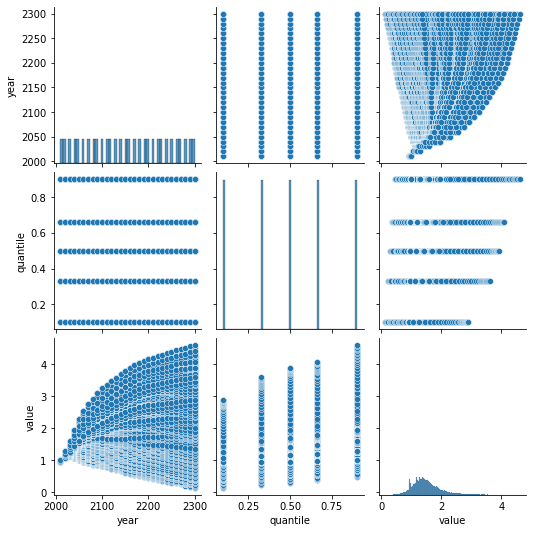

In [6]:
seaborn.pairplot(temp_years.data)

In [7]:
temps_90 = pyam.IamDataFrame(temps).filter(quantile=0.9).timeseries()
temps_50 = pyam.IamDataFrame(temps).filter(quantile=0.5).timeseries()
temps_10 = pyam.IamDataFrame(temps).filter(quantile=0.1).timeseries()
temps_90 = temps_90.reset_index(drop=True)
temps_50 = temps_50.reset_index(drop=True)
temps_10 = temps_10.reset_index(drop=True)
quantile_range = [10, 50, 90, "all"]
decomposers2 = {}
decomposers3 = {}
decomposers4 = {}
decomposers5 = {}
temp_data = {10: temps_10, 50: temps_50, 90:temps_90, "all": temps_py.timeseries()}
for i in quantile_range:
    decomposers2[i] = sklearn.decomposition.PCA(2).fit(temp_data[i])
    decomposers3[i] = sklearn.decomposition.PCA(3).fit(temp_data[i])
    decomposers4[i] = sklearn.decomposition.PCA(4).fit(temp_data[i])
    decomposers5[i] = sklearn.decomposition.PCA(5).fit(temp_data[i])

# Try random forest method

In [9]:
pcacols = ["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"]
# Switch between on and off to study the impact of considering all quantiles
if (False):
    pcadf = pd.DataFrame(
        decomposers5[50].fit_transform(temps_py.filter(quantile=0.5).timeseries()), 
        columns=pcacols,
        index=temps_py.filter(quantile=0.5).timeseries().index
    ).reset_index()
else:
    pcadf = pd.DataFrame(
        decomposers5["all"].fit_transform(temps_py.timeseries()), 
        columns=pcacols,
        index=temps_py.timeseries().index
    ).reset_index()

In [10]:
def decode_scen(df):
    df["factor2030"] = [float(x[1][:4]) for x in df["scenario"].str.split("2030fact")]
    df["nzdate"] = [int(x[1][:4]) for x in df["scenario"].str.split("_nz")]
    df["overshoot"] = [float(x[3][2:]) for x in df["scenario"].str.split("_")]
    df["methane"] = [float(x[4][4:]) for x in df["scenario"].str.split("_")]
    # The numerical stability of calculations is higher when variables are all of order 1
    df["nzreduced"] = df["nzdate"] / 100 - 20
    df["overshootreduced"] = df["overshoot"]/10000
    return df
pcadf = decode_scen(pcadf)
pcadf

,model,scenario,region,variable,unit,climate_model,quantile,PCA1,PCA2,PCA3,PCA4,PCA5,factor2030,nzdate,overshoot,methane,nzreduced,overshootreduced
0,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.10,-16.606031,-0.606375,-0.550879,-0.198509,-0.059129,0.12,2040,-10000.0,0.25,0.4,-1.0
1,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.33,-14.395001,0.050277,-0.394888,0.231765,0.252606,0.12,2040,-10000.0,0.25,0.4,-1.0
2,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.50,-13.262292,0.707713,-0.488155,0.202245,-0.076384,0.12,2040,-10000.0,0.25,0.4,-1.0
3,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.66,-12.460885,0.962608,-0.359962,0.328655,-0.135353,0.12,2040,-10000.0,0.25,0.4,-1.0
4,NameVanished,scen_2030fact0.12_nz2040_ov-10000_meth0.25,World,Surface Temperature,K,FaIRv1.6.4,0.90,-10.843689,1.450493,0.081718,0.531582,-0.279401,0.12,2040,-10000.0,0.25,0.4,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.10,15.816842,-2.100417,-0.617982,-0.454528,0.085754,1.32,2200,0.0,0.75,2.0,0.0
4496,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.33,24.519780,-2.150661,-0.453872,-0.401109,-0.070481,1.32,2200,0.0,0.75,2.0,0.0
4497,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.50,28.968867,-2.310612,-0.510951,0.112578,0.333311,1.32,2200,0.0,0.75,2.0,0.0
4498,NameVanished,scen_2030fact1.32_nz2200_ov0_meth0.75,World,Surface Temperature,K,FaIRv1.6.4,0.66,31.447401,-1.329638,-0.396346,-0.179470,-0.123920,1.32,2200,0.0,0.75,2.0,0.0


In [11]:
functional_cols = ["factor2030", "nzreduced", "overshootreduced", "methane"]
pcadf = pcadf.loc[:, ["quantile"] + functional_cols + pcacols]
pcadf

,quantile,factor2030,nzreduced,overshootreduced,methane,PCA1,PCA2,PCA3,PCA4,PCA5
0,0.10,0.12,0.4,-1.0,0.25,-16.606031,-0.606375,-0.550879,-0.198509,-0.059129
1,0.33,0.12,0.4,-1.0,0.25,-14.395001,0.050277,-0.394888,0.231765,0.252606
2,0.50,0.12,0.4,-1.0,0.25,-13.262292,0.707713,-0.488155,0.202245,-0.076384
3,0.66,0.12,0.4,-1.0,0.25,-12.460885,0.962608,-0.359962,0.328655,-0.135353
4,0.90,0.12,0.4,-1.0,0.25,-10.843689,1.450493,0.081718,0.531582,-0.279401
...,...,...,...,...,...,...,...,...,...,...
4495,0.10,1.32,2.0,0.0,0.75,15.816842,-2.100417,-0.617982,-0.454528,0.085754
4496,0.33,1.32,2.0,0.0,0.75,24.519780,-2.150661,-0.453872,-0.401109,-0.070481
4497,0.50,1.32,2.0,0.0,0.75,28.968867,-2.310612,-0.510951,0.112578,0.333311
4498,0.66,1.32,2.0,0.0,0.75,31.447401,-1.329638,-0.396346,-0.179470,-0.123920


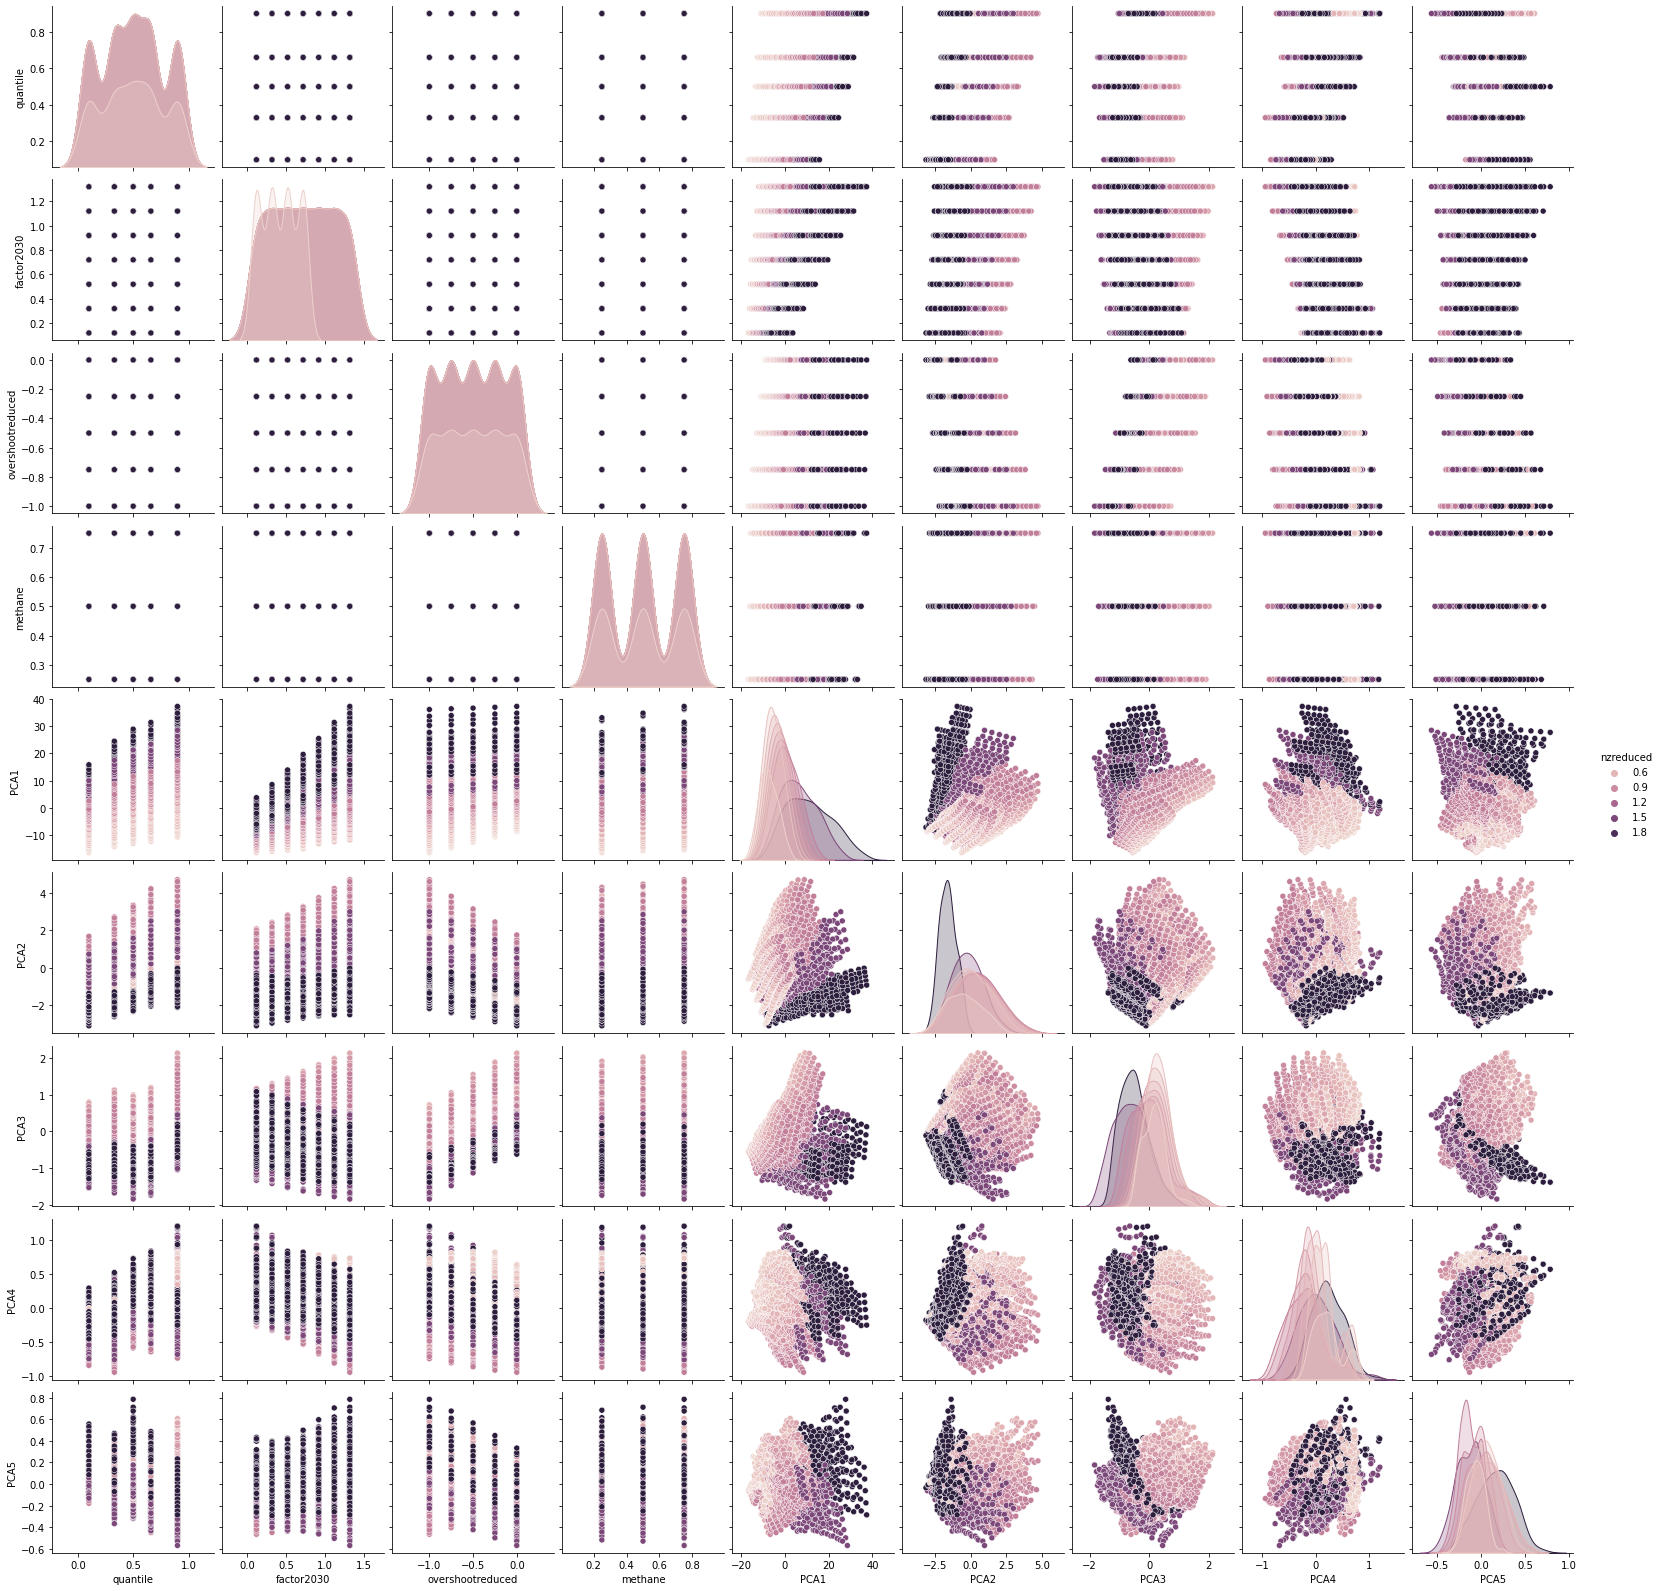

In [12]:
seaborn.pairplot(pcadf, hue="nzreduced")

In [13]:
pca_train, pca_test, pca_res_train, pca_res_test = train_test_split(
    pcadf.loc[:, pcacols + ["quantile"]], pcadf.loc[:, functional_cols], test_size = 0.2, random_state = 4
)

In [14]:
randforest = DecisionTreeRegressor()
randforest = randforest.fit(pca_train.values, pca_res_train.values)
randforest.score(pca_test.values, pca_res_test.values)

0.46877323116776504

In [15]:
pca_train

,PCA1,PCA2,PCA3,PCA4,PCA5,quantile
68,-2.107356,-1.623861,0.518272,0.207303,-0.208521,0.66
4312,7.963516,1.687641,-0.123958,-0.490519,-0.128070,0.50
1432,-9.808860,1.416086,-0.380326,0.165459,0.046273,0.50
3983,-2.950792,3.246133,0.256956,0.008769,0.165390,0.66
1310,-4.093134,-2.415950,-0.510034,-0.021124,0.182482,0.10
...,...,...,...,...,...,...
3671,5.061934,-0.320188,0.838836,-0.721938,0.006125,0.33
709,-5.426541,0.268421,0.315306,0.676555,-0.283645,0.90
2487,-0.527868,1.983508,-0.950998,-0.103829,-0.246867,0.50
174,-1.514114,-0.575675,0.551172,0.684069,-0.142814,0.90


In [16]:
pca_res_train

,factor2030,nzreduced,overshootreduced,methane
68,0.12,0.4,0.00,0.50
4312,1.32,1.0,-0.50,0.50
1432,0.52,0.5,-1.00,0.50
3983,1.32,0.6,-1.00,0.50
1310,0.32,2.0,-0.50,0.50
...,...,...,...,...
3671,1.12,0.9,0.00,0.75
709,0.32,0.4,-0.50,0.25
2487,0.72,1.0,-1.00,0.75
174,0.12,0.6,-0.25,0.50


[array([[1.        , 0.93060529],
        [0.93060529, 1.        ]]),
 array([[1.        , 0.95729639],
        [0.95729639, 1.        ]]),
 array([[1.        , 0.96223694],
        [0.96223694, 1.        ]]),
 array([[1.        , 0.06720115],
        [0.06720115, 1.        ]])]

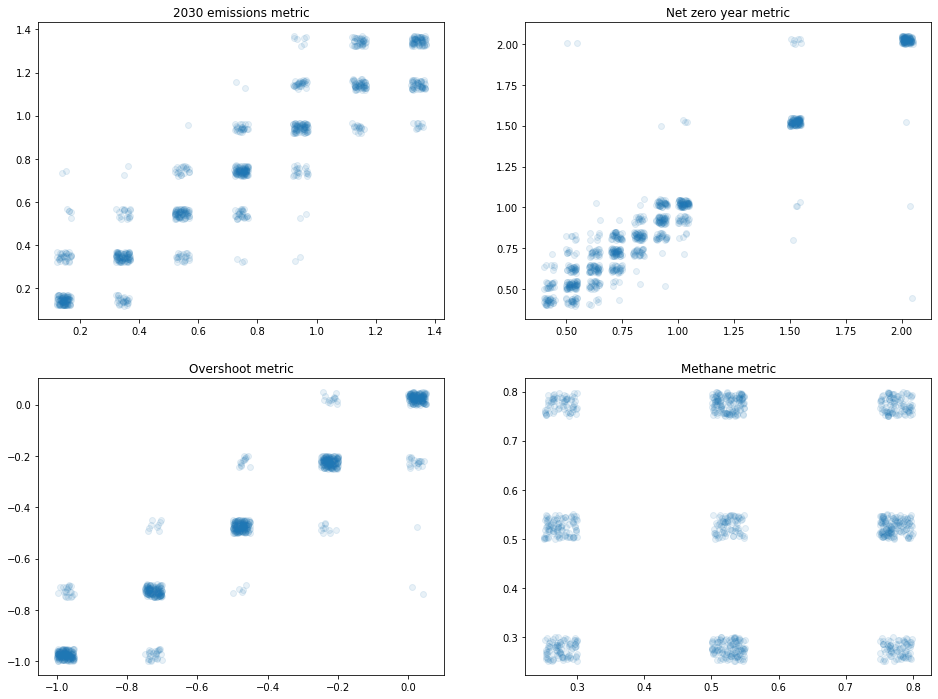

In [17]:
predictions = randforest.predict(pca_test.values)
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
corcoefs = []
plt.figure(figsize=(16, 12))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(predictions[:, i]+0.05*np.random.rand(len(predictions)), pca_res_test.iloc[:, i]+0.05*np.random.rand(len(predictions)), alpha=0.1)
    plt.title(titles[i])
    corcoefs.append(np.corrcoef(predictions[:, i], pca_res_test.iloc[:, i]))
corcoefs

# Try a polynomial relationship

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [25]:
# For smaller datasets, 5 polynomial degrees outperforms 6, but not for this dataset
poly = PolynomialFeatures(degree=6)
poly_train = poly.fit_transform(pca_train)
poly_test = poly.fit_transform(pca_test)

In [26]:
regression = linear_model.LinearRegression()
poly_model = regression.fit(poly_train, pca_res_train)
score = poly_model.score(poly_test, pca_res_test)
score

0.9698739072477951

In [30]:
poly_test

array([[ 1.00000000e+00, -6.31295590e+00, -1.63092564e+00, ...,
         9.89437831e-07,  9.94704896e-07,  1.00000000e-06],
       [ 1.00000000e+00,  2.76224544e+00,  1.23132344e-02, ...,
         3.48723858e-04, -2.33426868e-03,  1.56250000e-02],
       [ 1.00000000e+00, -8.07445066e+00,  1.89601069e+00, ...,
         1.86555907e-03,  5.39901477e-03,  1.56250000e-02],
       ...,
       [ 1.00000000e+00, -1.05591810e+01,  4.85823637e-02, ...,
         4.72092177e-08,  2.17276823e-07,  1.00000000e-06],
       [ 1.00000000e+00,  7.89734132e+00,  2.26229835e+00, ...,
         6.50047272e-03, -2.31795114e-02,  8.26539500e-02],
       [ 1.00000000e+00, -2.04974855e+00, -1.43607190e+00, ...,
         4.25835646e-08,  2.06357856e-07,  1.00000000e-06]])

In [27]:
pca_res_test

,factor2030,nzreduced,overshootreduced,methane
1675,0.52,0.8,-0.25,0.75
1927,0.52,1.5,-0.75,0.50
2707,0.92,0.5,-1.00,0.50
1773,0.52,0.9,-0.75,0.25
922,0.32,0.7,-0.25,0.50
...,...,...,...,...
3282,0.92,2.0,-0.75,0.75
859,0.32,0.6,-0.50,0.25
1725,0.52,0.9,-1.00,0.25
3718,1.12,1.0,-0.50,0.75


In [28]:
predicted = poly_model.predict(poly_test)

[array([[1.        , 0.99357238],
        [0.99357238, 1.        ]]),
 array([[1.        , 0.99080551],
        [0.99080551, 1.        ]]),
 array([[1.        , 0.99934746],
        [0.99934746, 1.        ]]),
 array([[1.        , 0.95601236],
        [0.95601236, 1.        ]])]

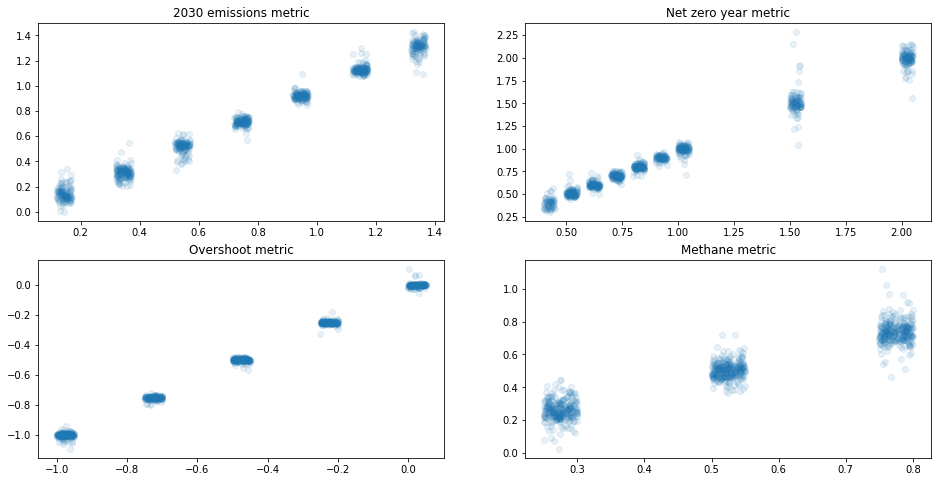

In [29]:
plt.figure(figsize=(16, 8))
corcoefs = []
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    plt.scatter(pca_res_test.iloc[:, i]+0.05*np.random.rand(len(predictions)), predicted[:, i], alpha=0.1)
    plt.title(titles[i])
    corcoefs.append(np.corrcoef(pca_res_test.iloc[:, i], predicted[:, i]))
corcoefs

In [41]:
# Interestingly, if the training data does not include different quantiles, 
# its ability to predict methane substantially declines (within the same quantile), indicating an overtraining risk
q50 = pcadf[pcadf["quantile"] == 0.5].index
q50_test_ind = [i in q50 for i in pca_res_test.index]

[array([[1.        , 0.99245776],
        [0.99245776, 1.        ]]),
 array([[1.        , 0.99580114],
        [0.99580114, 1.        ]]),
 array([[1.        , 0.99956689],
        [0.99956689, 1.        ]]),
 array([[1.        , 0.94419868],
        [0.94419868, 1.        ]])]

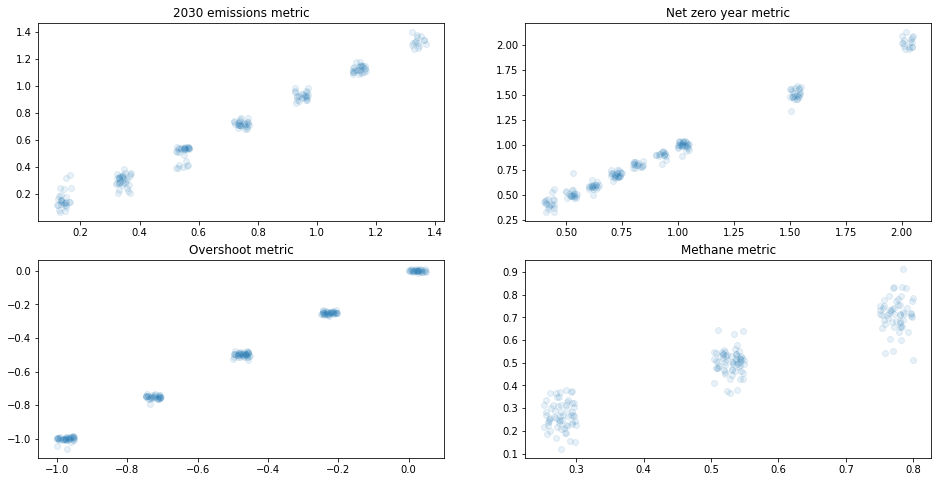

In [43]:
plt.figure(figsize=(16, 8))
corcoefsq5 = []
titles = ["2030 emissions metric", "Net zero year metric", "Overshoot metric", "Methane metric"]
for i in range(4):
    ax=plt.subplot(2, 2, i+1)
    plt.scatter(pca_res_test.iloc[q50_test_ind, i]+0.05*np.random.rand(sum(q50_test_ind)), predicted[q50_test_ind, i], alpha=0.1)
    plt.title(titles[i])
    corcoefsq5.append(np.corrcoef(pca_res_test.iloc[q50_test_ind, i], predicted[q50_test_ind, i]))
corcoefsq5